In [3]:
#!pip install geopandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas

In [4]:
df = pd.read_csv('https://s3grouparmenia.s3.eu-central-1.amazonaws.com/Transcripts_with_sentiment_topic')
df.head()

,Unnamed: 0,Year_x,Session_x,Country_x,Transcript,dominant_topic,topic_name,polarity,subjectivity,neg,neu,pos,compound
0,0,2018,73,BRB,let begin congratulate m maría fernanda espino...,1,human rights,0.078970,0.448072,0.113,0.687,0.200,0.9979
1,1,2018,73,IND,behalf behalf country india like begin congrat...,7,sustainable development,0.086980,0.466721,0.178,0.606,0.216,0.9825
2,2,2018,73,ARG,would like congratulate president election lea...,3,nuclear politics,0.111105,0.473726,0.139,0.593,0.268,0.9975
3,3,2018,73,JOR,honour take part debate wonderful bear ash sec...,3,nuclear politics,0.038658,0.447073,0.181,0.527,0.292,0.9980
4,4,2018,73,SWE,bit week honour late former secretary kofi ann...,3,nuclear politics,0.075395,0.453093,0.135,0.571,0.293,0.9995


In [ ]:
df['Year_x'].max()

2018

In [5]:
#filter years between 1990-2019

df2 = df[df['Year_x'] >= int('1990')]
df2['Year_x'].min()

1990

In [6]:
sus_df = df2[df2['topic_name'] == 'sustainable development']
len(sus_df)

576

In [7]:
group_df = sus_df.groupby(["Country_x"])[sus_df.columns[6]].count()
group_df = group_df.reset_index()
group_df.rename(columns={'topic_name':'count'}, inplace=True)
group_df

,Country_x,count
0,ALB,1
1,AND,18
2,ARG,7
3,ARM,3
4,ATG,1
...,...,...
120,VEN,19
121,VNM,1
122,VUT,2
123,ZAF,6


In [8]:
sdi = pd.read_excel('https://s3grouparmenia.s3.eu-central-1.amazonaws.com/SDI.xlsx')
sdi.head()

,iso,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AFG,Afghanistan,0.325,0.331,0.340,0.335,0.330,0.356,0.360,0.366,0.371,0.375,0.377,0.380,0.414,0.424,0.440,0.450,0.462,0.482,0.481,0.496,0.508,0.514,0.527,0.534,0.538,0.538,0.541,0.545,0.549,0.551
1,ALB,Albania,0.699,0.680,0.662,0.665,0.672,0.686,0.695,0.695,0.706,0.716,0.723,0.730,0.737,0.745,0.747,0.755,0.763,0.773,0.777,0.779,0.796,0.811,0.822,0.826,0.826,0.823,0.821,0.821,0.823,0.826
2,DZA,Algeria,0.616,0.621,0.627,0.631,0.635,0.640,0.649,0.658,0.669,0.678,0.686,0.697,0.708,0.719,0.729,0.738,0.744,0.753,0.756,0.766,0.776,0.785,0.784,0.785,0.791,0.794,0.798,0.800,0.801,0.803
3,AGO,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421,0.431,0.442,0.458,0.468,0.481,0.495,0.509,0.526,0.539,0.555,0.558,0.574,0.586,0.598,0.608,0.616,0.622,0.627,0.627,0.626
4,ATG,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512,0.400,0.418,0.537,0.662,0.659,0.630,0.649,0.635,0.621,0.620,0.617,0.616,0.619,0.622


In [9]:
sdi2 = pd.melt(frame=sdi ,id_vars=["iso", "country"],var_name="Year_x",value_name="SDI")
sdi_l = sdi2[sdi2['Year_x'] != '2019']
#sdi_l['Year_x']=sdi_l['Year_x'].astype(int)
sdi_l['Year_x'].max()

'2018'

In [10]:
group_sdi = sdi_l.groupby(["iso"])[sdi_l.columns[3]].mean()
group_sdi = group_sdi.reset_index()
group_sdi.rename(columns={'SDI':'SDI_mean'}, inplace=True)
group_sdi

,iso,SDI_mean
0,AFG,0.437552
1,AGO,0.537050
2,ALB,0.750828
3,ARE,0.137966
4,ARG,0.796552
...,...,...
160,WSM,0.717931
161,YEM,0.495172
162,ZAF,0.654759
163,ZMB,0.514966


In [11]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

str(world['name']).lower()
world
#world.plot()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [12]:
#map data merges with SDI data
merge_df1 = pd.merge(world, group_sdi,how = 'left', left_on=["iso_a3"], right_on=["iso"]).drop(columns='iso')

merge_df1

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,SDI_mean
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.756103
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.466517
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.288793
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.231276
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",0.548571
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",NaN
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0.731931


In [13]:
#merge with topic data
map_df = pd.merge(merge_df1, group_df,how = 'left', left_on=["iso_a3"], right_on=["Country_x"]).drop(columns="Country_x")
#normalize count to 0-1 range
diff1 = map_df["count"]-map_df["count"].min()
diff2 = map_df["count"].max()-map_df["count"].min()
map_df["normalized"] = diff1 / diff2
#implement index(change the name?)
map_df['index'] = map_df['normalized'] / map_df["SDI_mean"]

map_df

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,SDI_mean,count,normalized,index
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.756103,NaN,NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.466517,NaN,NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.288793,10.0,0.36,1.246567
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.231276,26.0,1.00,4.323841
...,...,...,...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",0.548571,2.0,0.04,0.072917
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",NaN,NaN,NaN,NaN
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN,NaN,NaN
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0.731931,NaN,NaN,NaN


In [17]:
from google.colab import files

map_df.to_csv('map_df.csv') 
files.download('map_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
len(map_df[map_df.isna().any(axis=1)])

79

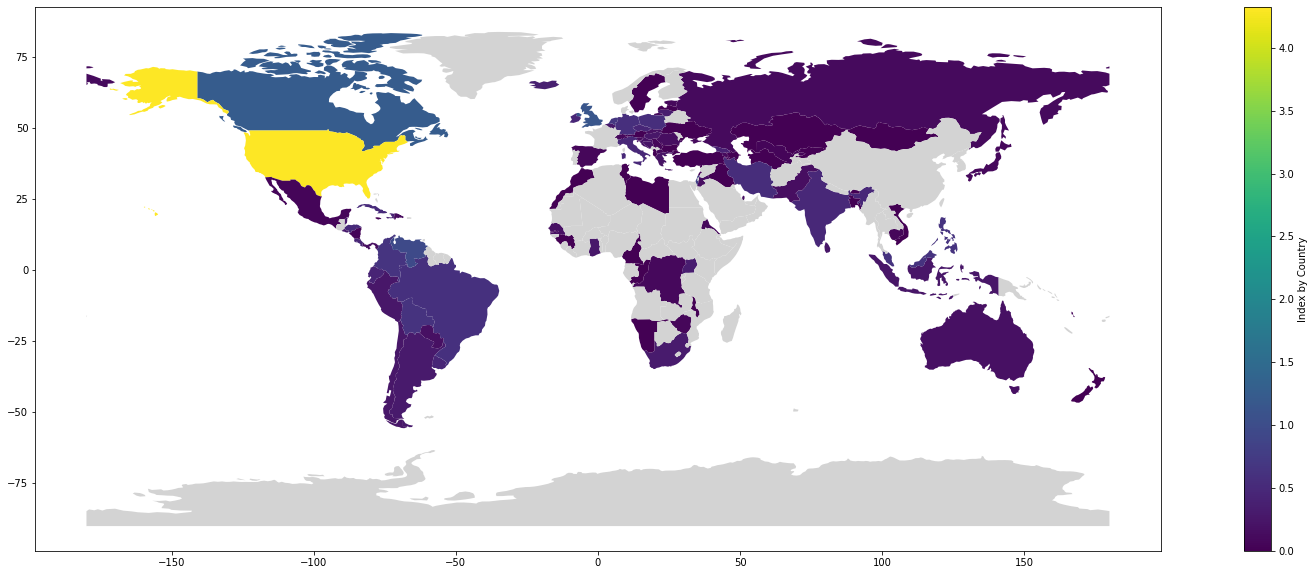

In [14]:
#coordination from speech to implement in improving sustainable environment
fig, ax = plt.subplots(1, figsize=(30, 10))
#map_df.plot(column = 'index', legend = True,ax=ax)
map_df.plot(column='index', ax=ax, legend=True, legend_kwds={'label': "Index by Country"},
            missing_kwds={ "color": "lightgrey","label": "Missing values"})

In [16]:
#Top 10 worst coordination from speech to implement in improving sustainable environment
map_df[['name','count','SDI_mean','index']].sort_values(by=['index'],ascending=False).head(10)

,name,count,SDI_mean,index
4,United States of America,26.0,0.231276,4.323841
3,Canada,10.0,0.288793,1.246567
143,United Kingdom,15.0,0.481414,1.163240
40,Venezuela,19.0,0.736345,0.977803
76,Israel,12.0,0.533276,0.825089
130,Netherlands,9.0,0.467621,0.684315
32,Colombia,13.0,0.736103,0.652082
30,Bolivia,12.0,0.686621,0.640820
147,Philippines,12.0,0.699586,0.628943
148,Malaysia,11.0,0.638276,0.626688


In [18]:
#Top 50 best coordination from speech to implement in improving sustainable environment
map_df[['name','count','SDI_mean','index']].sort_values(by=['index'],ascending=False).dropna().tail(50)

,name,count,SDI_mean,index
83,Jordan,4.0,0.755621,0.158810
85,Qatar,2.0,0.255276,0.156693
102,Pakistan,3.0,0.512690,0.156040
33,Panama,4.0,0.790103,0.151879
150,Slovenia,3.0,0.596179,0.134188
18,Russia,3.0,0.723607,0.110557
171,Macedonia,3.0,0.724842,0.110369
17,Dominican Rep.,3.0,0.725276,0.110303
109,Armenia,3.0,0.754893,0.105975
11,Dem. Rep. Congo,2.0,0.425414,0.094026


Index = normalized/SDI_mean

normalized: (normalized)counts on topics of sustainable environment by countries in 1990-2018

SDI: means of sustainable development index from 1990 to 2018

Smaller values of index indicate better coordination from speech to implement in improving sustainable environment and climate change problems.

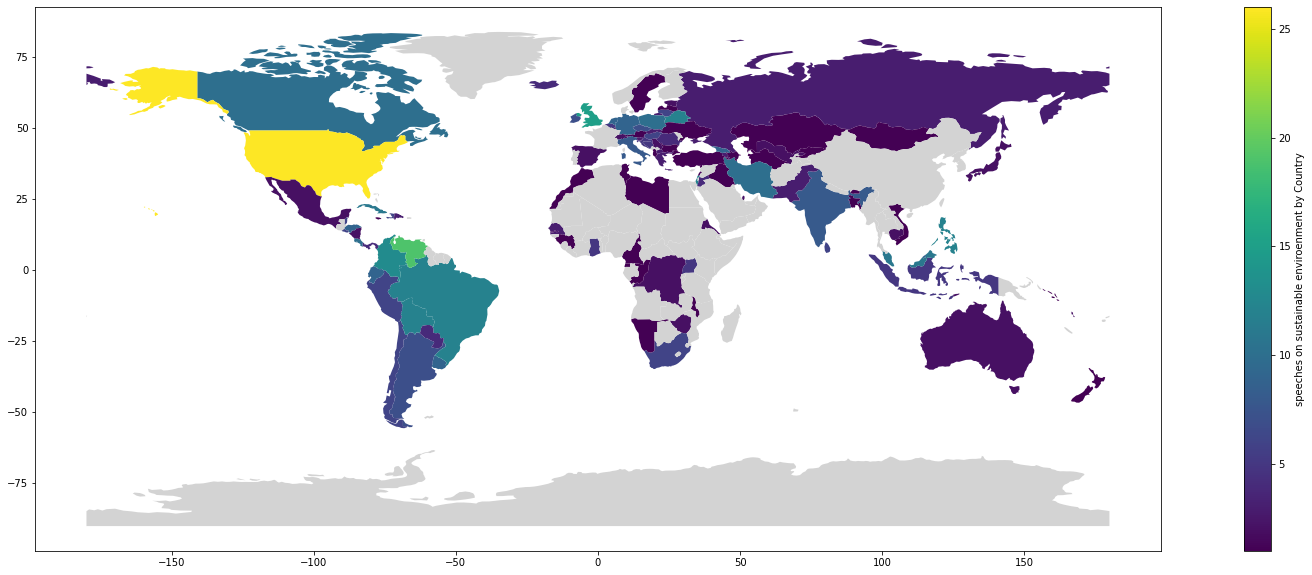

In [19]:
#who like to make speeches about sustainable enviroenment
fig, ax = plt.subplots(1, figsize=(30, 10))
map_df.plot(column='count', ax=ax, legend=True, legend_kwds={'label': "speeches on sustainable enviroenment by Country"},
            missing_kwds={ "color": "lightgrey","label": "Missing values"})

In [23]:
#Top 20 countries like to make speeches about sustainable enviroenment
map_df[['name','count','SDI_mean','index']].sort_values(by=['count'],ascending=False).dropna().head(20)

,name,count,SDI_mean,index
4,United States of America,26.0,0.231276,4.323841
40,Venezuela,19.0,0.736345,0.977803
143,United Kingdom,15.0,0.481414,1.163240
32,Colombia,13.0,0.736103,0.652082
30,Bolivia,12.0,0.686621,0.640820
29,Brazil,12.0,0.728034,0.604367
76,Israel,12.0,0.533276,0.825089
147,Philippines,12.0,0.699586,0.628943
148,Malaysia,11.0,0.638276,0.626688
47,Cuba,11.0,0.767034,0.521489


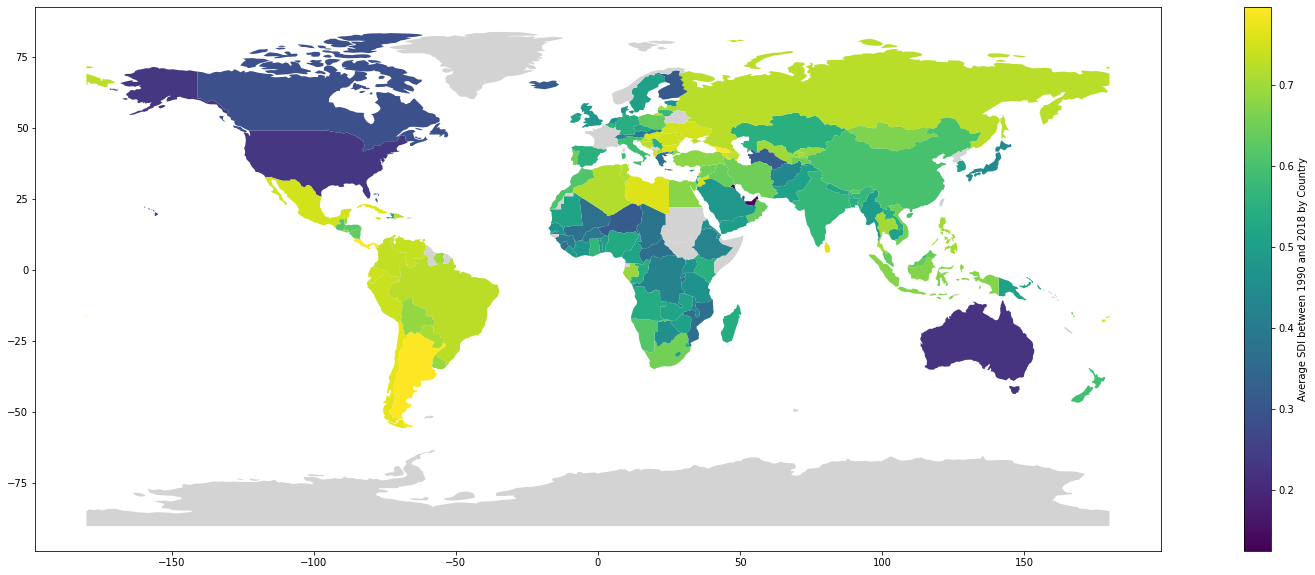

In [21]:
#who have the highest average SDI between 1990 and 2018
fig, ax = plt.subplots(1, figsize=(30, 10))
map_df.plot(column='SDI_mean', ax=ax, legend=True, legend_kwds={'label': "Average SDI between 1990 and 2018 by Country"},
            missing_kwds={ "color": "lightgrey","label": "Missing values"})

In [24]:
#Top 20 highest average SDI between 1990 and 2018
map_df[['name','count','SDI_mean','index']].sort_values(by=['SDI_mean'],ascending=False).dropna().head(20)

,name,count,SDI_mean,index
9,Argentina,7.0,0.796552,0.301299
146,Georgia,9.0,0.792684,0.403692
34,Costa Rica,10.0,0.792000,0.454545
33,Panama,4.0,0.790103,0.151879
10,Chile,6.0,0.769034,0.260066
138,Sri Lanka,6.0,0.767379,0.260627
47,Cuba,11.0,0.767034,0.521489
164,Libya,1.0,0.760724,0.000000
122,Bulgaria,1.0,0.760655,0.000000
115,Hungary,6.0,0.756172,0.264490


Calculation of SDI

https://www.sustainabledevelopmentindex.org/methods